<img src="images/banner.png" align="left">

# Introduction

This notebook walks through a breif example showing how to generate an arbitrary waveform and channelize it using a 4096-channel, 50% overlapping polyphase filter bank on a ZCU111 with external loopback via the integrated RF Data Converter. This notebook demonstrates some of basic functions we have developed to support the readout of two-thousand, multiplexed superconducting detectors. This work is part of a broader effort in Ben Mazin's group at UCSB to develop instruments featuing arrays of cryogenic detectors for astronomy imaging applications. Check out our [lab website](https://web.physics.ucsb.edu/~bmazin/) to learn more about the research group. To learn more about the FPGA project, check out our [latest update on arXiv](https://arxiv.org/abs/2203.16520). The full project is still under development but the current stats is available on Github [here](https://github.com/MazinLab/MKIDGen3).

## 1. System Overview <a class="anchor" id="system"></a>

The full superconducting detector readout system block design is shown below. In this demonstration notebook, we will be showcasing the DAC Replay, OPFB, Bin Select, and Calibration Capture systems which are highlighted in yellow. All of these IP blocks are implemented with a combination of Vitis High-Level Syntheis and pre-existing Xilinx IP available in Vivado IPI. The one exception is the capture subsystem which uses an [open source RTL core](https://github.com/MazinLab/wb2axip/tree/master) to convert AXIS to AXI burst writes to the MIG because (as far as we can tell) this is not possible with HLS as of version 2021.1.

<img src="images/full_block_design.png" alt="drawing" width="600"/>

## 1.1 Hardware Setup <a class="anchor" id="hardware"></a>

To fully run this notebook, you will need to have a ZCU111 with the XM500 Balun card attached. Connect ADC tile 224 block 0 (J4) to DAC tile 229 block 2 (J5) and ADC tile 224 block 1 (J3) to DAC tile 229 block 3 (J6). The block 0 data converters will be the "I channel" and the block 1 data converters will be the "Q channel". This will allow us to access 4 GHz of Nyquist bandwith in the [-2048, 2048) MHz range. Keep in mind the data converters we are using in this demo are coupled to a 0-1 GHz balun and 3dB pi attenuator. 

<img src="images/hardware_setup.png" alt="drawing" width="500"/>

## 1.2 Overlay Design <a class="anchor" id="overlay"></a>

The overlay design is built in Vivado 2021.2. The design sources all clocks from the RFDC ADC and DAC tile PLL's. All optional resets in the design have been tied off to improve timing performance and resource utilization. Note the RFDC, DAC Replay, and MIG blocks require functioning resets. 

## 1.3 Import Drivers+, Download Overlay <a class="anchor" id="import"></a>

In [53]:
from pynq import PL, Overlay

import numpy as np
import matplotlib.pyplot as plt
import mkidgen3.fccm22_demo

from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.plotting import adc_test_plot, plot_opfb_bins
from mkidgen3.drivers import axiswitch, bintores, dactable, axififo, rfdc
from mkidgen3 import capture_opfb, configure

In [37]:
# Download Overlay
ol = configure('opfb_streaming.bit', clocks=False, external_10mhz=False, ignore_version=True)

print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/jupyter_notebooks/opfb_streaming.bit
PL Timestamp: 2022/7/14 0:0:8 +783610
Overlay timestamp: 2022/7/14 0:0:8 +783610  Loaded: True


# 2. IP Blocks <a class="anchor" id="ip"></a>

The demo overlay contains four major IP subsystems: DAC Replay, OPFB, Bin Select, and Capture. The remainder of this notebook will walk you through the IP we have developed and how to use them.

## 2.1 DAC Replay <a class="anchor" id="dacreplay"></a>
The DAC Replay is a Vitis HLS IP. The source code along with the exported IP is available [here](https://github.com/MazinLab/dac-replay/tree/master). The DAC Replay IP is implemented as a 60 URAM look-up-table which totals 2MiB of waveform data. The URAM is programmed with 2^19 complex values where the real and complex parts are each 16-bits. The real and complex signal components are fed to two RFSoC DACs each running at 4.096 GSPS. This allows us to generate arbitrary waveforms in the [-2048 MHz, 2048 MHz) range with 4.096 GHz / 2^19 =  7.8125 KHz resolution. 

The DAC Replay IP supports replaying all 2^19 samples in a loop or a smaller (integer multiple of 16) range of samples. The IP also supports generating a TLAST signal on a group of 16 samples. The IP outputs two 256-bit AXI-4 streams at 256 MHz, one feeds the I DAC and the other the Q DAC. An example of the AXI4-Stream format for the real data (I DAC) is shown below. 


In [38]:
import nbwavedrom as wd

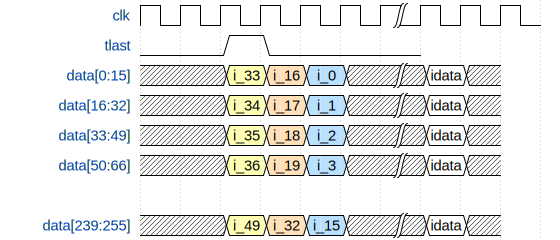

In [39]:
wd.draw({
'signal': [
  {'name': 'clk', 'wave': 'p.....|...'},
  {'name': 'tlast', 'wave': '0.10...'},
  {'name': 'data[0:15]', 'wave': 'x.345x|=x', 'data': ['i_33', 'i_16','i_0','idata']},
  {'name': 'data[16:32]', 'wave': 'x.345x|=x', 'data': ['i_34', 'i_17','i_1','idata']},
  {'name': 'data[33:49]', 'wave': 'x.345x|=x', 'data': ['i_35', 'i_18','i_2','idata']},
  {'name': 'data[50:66]', 'wave': 'x.345x|=x', 'data': ['i_36', 'i_19','i_3','idata']},
  {},
  {'name': 'data[239:255]', 'wave': 'x.345x|=x', 'data': ['i_49', 'i_32','i_15','idata']},
]})

The core is programmed over AXI4-Lite using the DAC Replay Python driver availbale [here](https://github.com/MazinLab/MKIDGen3/blob/develop/mkidgen3/drivers/dactable.py). This core is nominally used to feed two RFSoC DACs but it is also possible to stream data to other DSP logic within the FPGA fabric to test IP subsystems with data manufactured in Python. Please contact the authors to learn more about this use case.

### DAC Waveform

The following cells demonstrate how to construct an arbitrary waveform and play it out of the DACs.

In [40]:
#Set tones to send (in Hz). Domain is [-2047,2048) MHz. Set the SNR for a noise floor, `'max'` will turn off noise.
tones = np.array([300e6, 300.5e6])
amplitudes = np.ones_like(tones)/tones.shape[0]
snr = 'max'

In [41]:
Ns=2**19 # fill the DAC LUT Table
in_noise = 0
if snr != 'max':
    a_noise = 10**((20*np.log10(1/np.sqrt(2)) - snr)/10)
    in_noise = np.sqrt(a_noise)*(np.random.uniform(-1,1,size=Ns) + 1j*np.random.uniform(-1,1,size=Ns))

In [42]:
# Compute the waveform
dactable = generate_dac_comb(frequencies=tones, n_samples=Ns, sample_rate=4.096e9, amplitudes=amplitudes)
if snr != 'max':
    dactable['iq']+=in_noise
    dactable['iq']/=max(dactable['iq'].real, dactable['iq'].imag)
    pass

In [43]:
# Program URAM and run DAC Table
if ol.dac_table.register_map.run.run:
    ol.dac_table.stop()
ol.dac_table.replay(dactable['iq'], fpgen='simple')

At this point, you should be able to measure the DAC output using a Spectrum Analyzer or Oscilloscope. You can also use the RFSoC ADCs! Keep scrolling to see how.

### Capture & Plot DAC Output Using RFSoC ADCs

With the ZCU111 connected in loopback, we can sample the DAC output with the RFSoC ADCs and capture the result to the PL DRAM where we can visualize it in this notebook.

In [44]:
N = Ns # Number of samples to capture (full waveform)
Fs = 4.096e9 # ADC Sample Rate [Hz]
Tc = N/Fs # total collection time (seconds)

In [45]:
# Trigger Capture
adc_capture_data = ol.capture.capture_adc(N, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V

Capture does not support phase capture


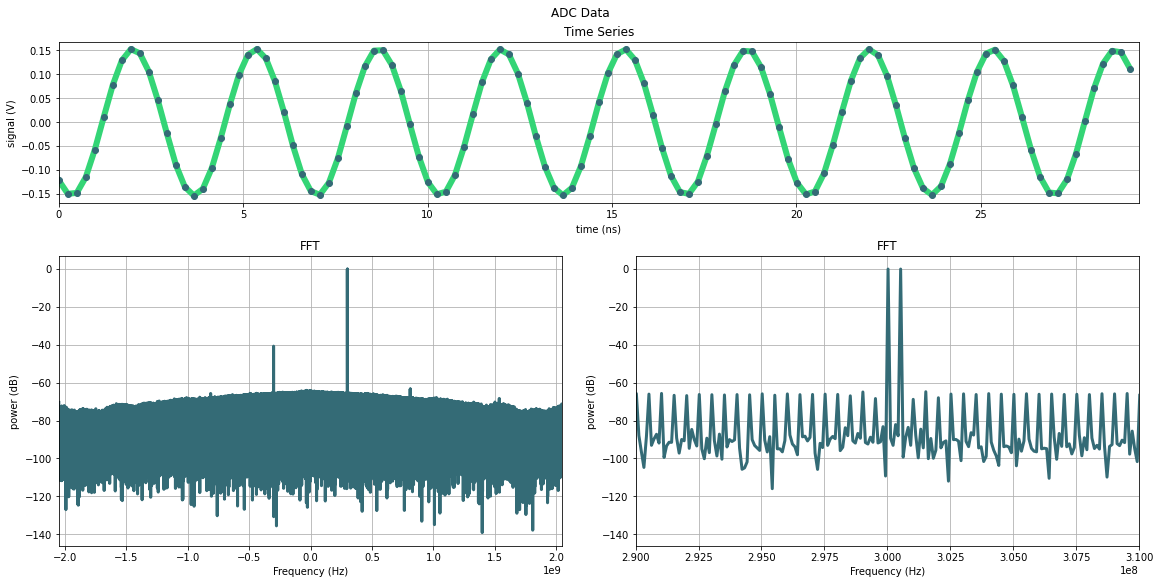

In [46]:
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (2.9e8, 3.1e8)
adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

## 2.2 Oversampled Polyphase Filter Bank (OPFB) <a class="anchor" id="opfb"></a>

The OPFB is a 4,096-channel, 2/1 oversampled 4 GHz channelizer. It takes in 2, 4.096 GSPS data streams--one from and I ADC and the other from a Q ADC, and produces 4096 2 MHz channels which overlap by 50%. This overlapping feature insures that no matter where a signal exists in-band, it will be able to pass through the channelizer un-attenuated. This IP is the subject of [this publication](https://ieeexplore.ieee.org/document/9336352) and is also documented in a [stand-alone git repo](https://github.com/MazinLab/RFSoC_OPFB).

After being sampled by the ADCs, we can run the data through the OPFB IP and capture the result to the PPL DDR4 for visualization.

### OPFB Capture

<script src="https://cdnjs.cloudflare.com/ajax/libs/wavedrom/2.6.8/skins/default.js" type="text/javascript"></script>
<body onload="WaveDrom.ProcessAll()">
<script type="WaveDrom">
{ signal : [
  { name: "clk",  wave: "p......" },
  { name: "bus",  wave: "x.34.5x",   data: "head body tail" },
  { name: "wire", wave: "0.1..0." },
]}
</script>

In [47]:
# Capture N samples from all 4096 OPFB Bins
opfb_raw = capture_opfb(1024, raw=True)
# Convert to complex numbers
opfb_fp = opfb_raw[..., 0] + 1j*(opfb_raw[..., 1])

### Plot OPFB

In [48]:
all_bins = np.linspace(0,4095,4096).astype(int).tolist()

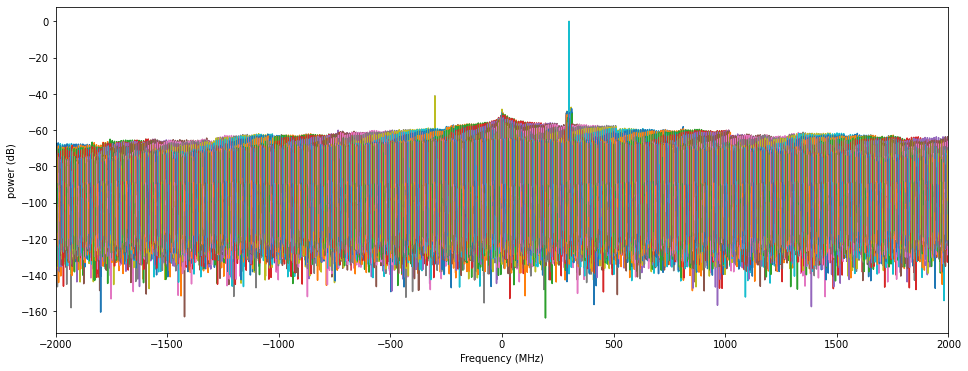

In [49]:
plot_opfb_bins(opfb_fp,all_bins);

We expect our 300 MHz tone to be in bin 2348. Because the channelizer is 50% overlapping, we also expect to see the 300.5 MHz tone in that bin as well as the neighboring bin with equal magnitude in each bin. Indeed we see that is the case below.

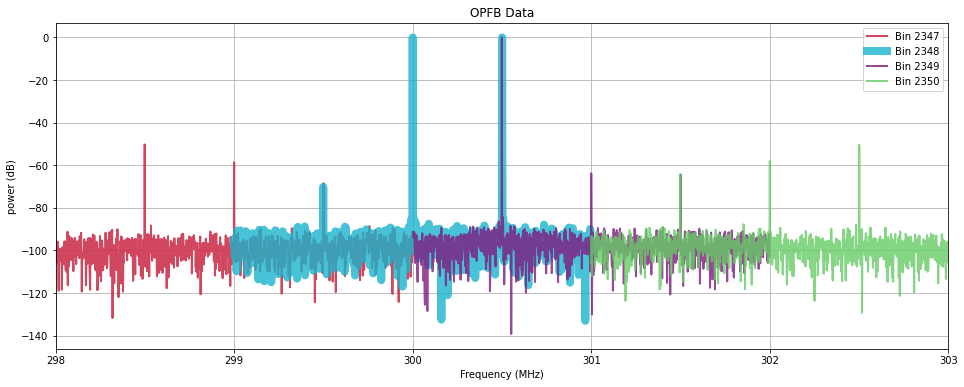

In [54]:
mkidgen3.fccm22_demo.plot_fccm_demo_bins(opfb_fp)